# Test the performance of MDM vs QDM + Sort for the globe

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
catalog_url = 'https://data.rda.ucar.edu/harshah/intake_catalogs/posix/cesm2-lens/rda-cesm2-lens-posix.json'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [5]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [6]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  

In [7]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

In [8]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    #obs_mean   = ds_obs.mean('year')
    ds_shift   = ds_obs + (final_mean - init_mean) 
    return ds_shift 
    
def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [9]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36943 instead
  warnings.warn(


In [11]:
# Create the client to load the Dashboard
client = Client(cluster)

In [12]:
n_workers = 15
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(1e5ce2c9, 'tcp://128.117.208.95:40165', workers=8, threads=8, memory=64.00 GiB)

## Compare QDM + Sort and MDM 

### Load CESM2 daily temperature data

In [14]:
var_name    = 'tmax'
folder_path = tmax_path
det_var     = 'detrended_tmax'
temp_var    = 'TREFHTMX'

In [18]:
%%time
pi_daily  = xr.open_zarr(folder_path + f'pre_ind_daily_{var_name}.zarr')
eoc_daily = xr.open_zarr(folder_path + f'eoc_daily_{var_name}.zarr')
#
pi_daily = pi_daily[temp_var]
eoc_daily = eoc_daily[temp_var]
#
pi_daily

CPU times: user 684 ms, sys: 69.7 ms, total: 754 ms
Wall time: 1.03 s


<xarray.DataArray 'TREFHTMX' (member_id: 100, lat: 192, lon: 288, year: 30,
                              dayofyear: 365)> Size: 242GB
dask.array<open_dataset-TREFHTMX, shape=(100, 192, 288, 30, 365), dtype=float32, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [19]:
pi_detrended  = xr.open_zarr(folder_path + f'pre_ind_detrended_{var_name}.zarr')
eoc_detrended = xr.open_zarr(folder_path + f'eoc_detrended_{var_name}.zarr')
#
pi_detrended = pi_detrended[det_var]
eoc_detrended = eoc_detrended[det_var]

In [14]:
######################

In [15]:
# Total range of numbers
total_range = list(range(1, 100))

# Generate the first list of N unique random numbers
N = 8
random.seed(42) 
model_list = random.sample(total_range, N)

# Remove these numbers from the total range to avoid repetition
remaining_range = [num for num in total_range if num not in model_list]

# Generate the second list of 10 unique random numbers from the remaining numbers
obs_list = random.sample(remaining_range, N)

model_list = model_list + [99,0]
obs_list   = obs_list + [0,99]

# Pair the numbers together
paired_numbers = list(zip(model_list, obs_list))
#

# Print the pairs
print("List of pairs:")
for pair in paired_numbers:
    print(pair)

List of pairs:
(82, 16)
(15, 94)
(4, 76)
(95, 13)
(36, 83)
(32, 61)
(29, 6)
(18, 5)
(99, 0)
(0, 99)


### Select Observation and Model indices. 

In [16]:
## Get member_ids for observations and model runs
obs_ids   =  pi_daily.isel(member_id = obs_list)['member_id']
model_ids = pi_detrended.isel(member_id = model_list)['member_id']
obs_ids

<xarray.DataArray 'member_id' (member_id: 10)> Size: 480B
array(['r3i1231p1f1', 'r4i1071p1f2', 'r17i1251p1f2', 'r2i1281p1f1',
       'r19i1231p1f2', 'r13i1281p1f2', 'r1i1231p1f1', 'r1i1001p1f1',
       'r10i1181p1f1', 'r9i1171p1f2'], dtype='<U12')
Coordinates:
  * member_id  (member_id) <U12 480B 'r3i1231p1f1' ... 'r9i1171p1f2'

In [17]:
############ Select some ensemble members as obs and others as model ######
#
pi_obs  = pi_daily.sel(member_id = obs_ids)
eoc_obs = eoc_daily.sel(member_id= obs_ids)
#
pi_model_det  = pi_detrended.sel(member_id = model_ids)
eoc_model_det = eoc_detrended.sel(member_id= model_ids)
#
pi_model  = pi_daily.sel(member_id = model_ids)
eoc_model = eoc_daily.sel(member_id = model_ids)
#
pi_model  = pi_model.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
eoc_model = eoc_model.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
#
pi_obs    = pi_obs.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
eoc_obs   = eoc_obs.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
#
pi_model_det  = pi_model_det.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
eoc_model_det = eoc_model_det.chunk({'lat':8,'lon':40,'member_id':-1,'year':10})
eoc_obs

<xarray.DataArray 'TREFHTMX' (member_id: 10, lat: 192, lon: 288, year: 30,
                              dayofyear: 365)> Size: 24GB
dask.array<rechunk-merge, shape=(10, 192, 288, 30, 365), dtype=float32, chunksize=(10, 8, 40, 10, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 480B 'r3i1231p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [18]:
pi_model  = pi_model.rename({'member_id':'model_id'})
eoc_model = eoc_model.rename({'member_id':'model_id'})
#
pi_model_det  = pi_model_det.rename({'member_id':'model_id'})
eoc_model_det = eoc_model_det.rename({'member_id':'model_id'})
#
pi_obs     = pi_obs.rename({'member_id':'obs_id'})
eoc_obs    = eoc_obs.rename({'member_id':'obs_id'})

In [19]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
# pi_mmean

## Perform Moment Delta Mapping

In [20]:
pi_mdm  = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)
# pi_mdm

In [21]:
pi_shift = implement_shift(pi_obs,pi_mmean,eoc_mmean)

In [22]:
qpi_mdm   = compute_quantiles(pi_mdm)
qpi_shift = compute_quantiles(pi_shift)
#
# qpi_shift = qpi_shift.chunk({'obs_id':1})
# qpi_mdm   = qpi_mdm.chunk({'obs_id':1})
qpi_mdm

<xarray.DataArray (quantile: 30, obs_id: 10, lat: 192, lon: 288,
                   dayofyear: 365, model_id: 10)> Size: 484GB
dask.array<transpose, shape=(30, 10, 192, 288, 365, 10), dtype=float64, chunksize=(30, 10, 8, 40, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) <U12 480B 'r3i1231p1f1' 'r4i1071p1f2' ... 'r9i1171p1f2'
  * model_id   (model_id) <U12 480B 'r18i1301p1f2' ... 'r10i1181p1f1'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [23]:
# %%time
# qpi_mdm.rename(var_name).to_dataset().to_zarr(folder_path +'qpi_mdm_100examples.zarr',mode='w')

In [24]:
# %%time
# qpi_shift.rename(var_name).to_dataset().to_zarr(folder_path +'qpi_shift_100examples.zarr',mode='w')

## Perform Quantile Delta Mapping

In [25]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)
#
qano     = qeoc_model - qpi_model

In [26]:
qpi_qdm =  qpi_obs + qano
#
# qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'TREFHTMX' (quantile: 30, obs_id: 10, lat: 192, lon: 288,
                              dayofyear: 365, model_id: 10)> Size: 484GB
dask.array<add, shape=(30, 10, 192, 288, 365, 10), dtype=float64, chunksize=(30, 10, 8, 40, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) <U12 480B 'r3i1231p1f1' 'r4i1071p1f2' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U12 480B 'r18i1301p1f2' ... 'r10i1181p1f1'

In [27]:
# %%time
# qpi_qdm.rename(var_name).to_dataset().to_zarr(folder_path +'qpi_qdm_100examples.zarr',mode='w')

## MDM vs QDM

In [28]:
qpi_mdm_ds   = xr.open_zarr(folder_path+'qpi_mdm_100examples.zarr')
qpi_qdm_ds   = xr.open_zarr(folder_path+'qpi_qdm_100examples.zarr')
qpi_shift_ds = xr.open_zarr(folder_path+'qpi_shift_100examples.zarr')
#
qpi_mdm      = qpi_mdm_ds[var_name]
qpi_shift    = qpi_shift_ds[var_name]
qpi_qdm      = qpi_qdm_ds[var_name]
# qpi_mdm

## Select model and observations and plot

In [1]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
# qpi_sqdm

NameError: name 'xr' is not defined

### Plot and check for individual locations

In [30]:
# Function to select data for a given variable name, dayofyear, lat, lon, model_id, and obs_id
# Get model and observation IDs
# model_id = model_ids[-1] # Corresponds to index 0
model_id = model_ids[-2]
obs_id = obs_ids[-1]     # Corresponds to index 99


# Define the locations and their corresponding latitudes and longitudes
locations = {
    'Bengaluru': {'LAT': ben_lat, 'LON': ben_lon},
    'Chicago': {'LAT': chic_lat, 'LON': chic_lon}
}

# Dictionary of DataArrays and Plotting Styles
variables = {
    'qpi_mdm': {'data': qpi_mdm, 'style': '--', 'color': 'green', 'label': 'PI + MDM'},
    'qpi_qdm': {'data': qpi_qdm, 'style': '--', 'color': 'tab:orange', 'label': 'QDM'},
    'qpi_shift': {'data': qpi_shift, 'style': '--', 'color': 'black', 'label': 'PI + shift'},
    'qpi_sqdm': {'data': qpi_sqdm, 'style': '--', 'color': 'purple', 'label': 'PI + SQDM'},
    #'qpi_model': {'data': qpi_model, 'style': '-', 'color': 'blue', 'label': 'PI Model'},
    'qpi_obs': {'data': qpi_obs, 'style': '-', 'color': 'red', 'label': 'PI Obs'},
    'qeoc_obs': {'data': qeoc_obs, 'style': '-', 'color': 'brown', 'label': 'EOC Obs'}
}


# Generalized Function to Select Data
def select_data(array, key, doy, LAT, LON, model_id, obs_id):
    """
    General function to select data for a given dayofyear, lat, lon, model_id, and obs_id.
    Applies different selection patterns based on array type.
    """
    # Common selection for dayofyear and location
    selected = array.sel(dayofyear=doy).sel(lat=LAT, lon=LON, method='nearest')
    
    # Special logic for arrays without both model_id and obs_id
    if key == 'qpi_model':
        # qpi_model only has model_id
        return selected.sel(model_id=model_id)
    elif key in ['qpi_obs', 'qeoc_obs']:
        # qpi_obs and qeoc_obs only have obs_id
        return selected.sel(obs_id=obs_id)
    else:
        # General case for all other arrays
        return selected.sel(model_id=model_id).sel(obs_id=obs_id)

In [30]:
# Function to select data for a given variable name, dayofyear, lat, lon, model_id, and obs_id
# Get model and observation IDs
# model_id = model_ids[-1] # Corresponds to index 0
model_id = model_ids[-2]
obs_id = obs_ids[-1]     # Corresponds to index 99


# Define the locations and their corresponding latitudes and longitudes
locations = {
    'Bengaluru': {'LAT': ben_lat, 'LON': ben_lon},
    'Chicago': {'LAT': chic_lat, 'LON': chic_lon}
}

# Dictionary of DataArrays and Plotting Styles
variables = {
    'qpi_mdm': {'data': qpi_mdm, 'style': '--', 'color': 'green', 'label': 'PI + MDM'},
    'qpi_qdm': {'data': qpi_qdm, 'style': '--', 'color': 'tab:orange', 'label': 'QDM'},
    'qpi_shift': {'data': qpi_shift, 'style': '--', 'color': 'black', 'label': 'PI + shift'},
    'qpi_sqdm': {'data': qpi_sqdm, 'style': '--', 'color': 'purple', 'label': 'PI + SQDM'},
    #'qpi_model': {'data': qpi_model, 'style': '-', 'color': 'blue', 'label': 'PI Model'},
    'qpi_obs': {'data': qpi_obs, 'style': '-', 'color': 'red', 'label': 'PI Obs'},
    'qeoc_obs': {'data': qeoc_obs, 'style': '-', 'color': 'brown', 'label': 'EOC Obs'}
}


# Generalized Function to Select Data
def select_data(array, key, doy, LAT, LON, model_id, obs_id):
    """
    General function to select data for a given dayofyear, lat, lon, model_id, and obs_id.
    Applies different selection patterns based on array type.
    """
    # Common selection for dayofyear and location
    selected = array.sel(dayofyear=doy).sel(lat=LAT, lon=LON, method='nearest')
    
    # Special logic for arrays without both model_id and obs_id
    if key == 'qpi_model':
        # qpi_model only has model_id
        return selected.sel(model_id=model_id)
    elif key in ['qpi_obs', 'qeoc_obs']:
        # qpi_obs and qeoc_obs only have obs_id
        return selected.sel(obs_id=obs_id)
    else:
        # General case for all other arrays
        return selected.sel(model_id=model_id).sel(obs_id=obs_id)

In [31]:
# Convert model_id and obs_id to native Python strings
model_id_str = model_id.item() if isinstance(model_id, xr.DataArray) else model_id
obs_id_str = obs_id.item() if isinstance(obs_id, xr.DataArray) else obs_id
#
print(model_id_str,obs_id_str)

r9i1171p1f2 r9i1171p1f2


In [32]:
# Calculate quantile curves for both locations
quantile_data = {}
for location, coords in locations.items():
    LAT, LON = coords['LAT'], coords['LON']
    quantile_data[location] = {}
    for key, value in variables.items():
        # Apply the selection function to each DataArray
        quantile_data[location][key] = select_data(value['data'], key, doy, LAT, LON, model_id, obs_id)


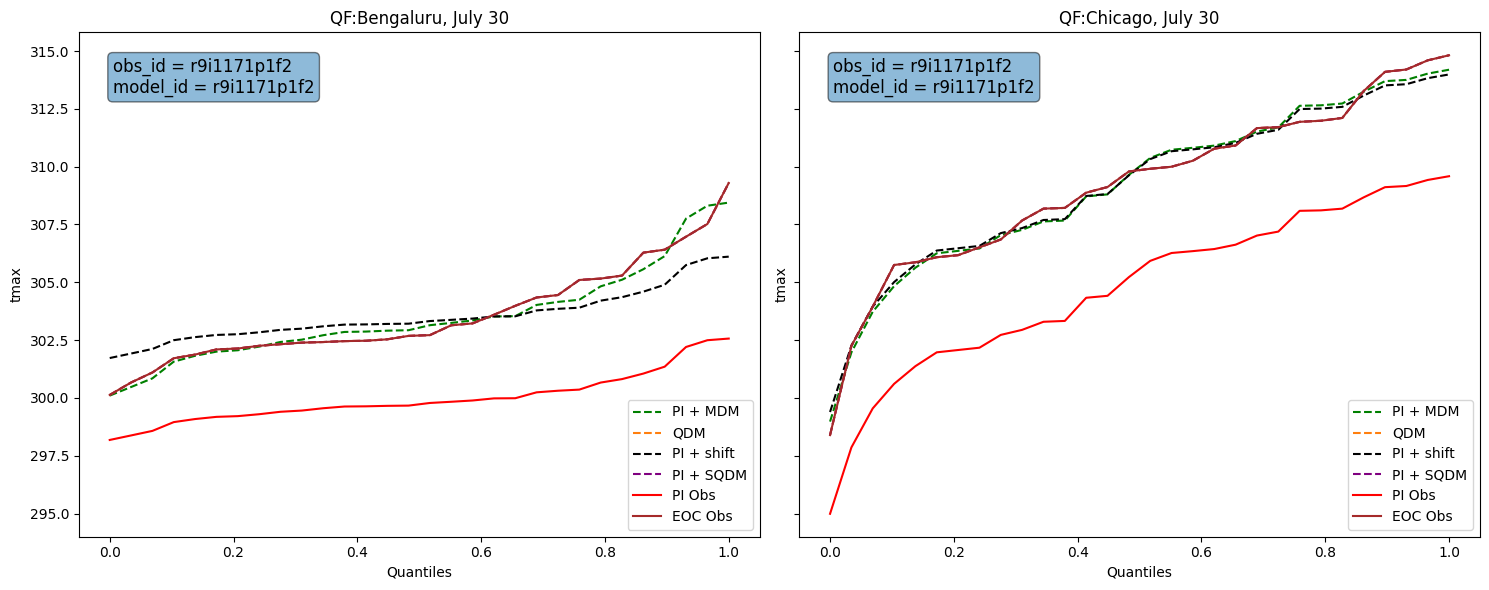

CPU times: user 4.48 s, sys: 2.91 s, total: 7.39 s
Wall time: 11.7 s


In [33]:
%%time
# Plot quantile curves side by side for both locations
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, (location, data) in zip(axs, quantile_data.items()):
    for key, value in variables.items():
        ax.plot(quants, data[key], value['style'], color=value['color'], label=value['label'])
    # Add labels, title, legend, and text
    text_str = f'obs_id = {obs_id_str}\nmodel_id = {model_id_str}'
    ax.set_xlabel('Quantiles')
    ax.set_ylabel(var_name)
    ax.set_title('QF:'+ location + ', ' + date)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [34]:
%%time
# Dictionary to store sortedness check results
sorted_results = {}

# Loop through locations and variables
for location, data in quantile_data.items():
    sorted_results[location] = {}
    for key, array in data.items():
        # Check if the quantile values are sorted
        sorted_results[location][key] = is_sorted(array.values)

# Display Results
print("Quantile Function Sortedness Check:")
for location, results in sorted_results.items():
    print(f"\nLocation: {location}")
    for key, is_sorted_flag in results.items():
        status = "Sorted" if is_sorted_flag else "Not Sorted"
        print(f"  {key}: {status}")

Quantile Function Sortedness Check:

Location: Bengaluru
  qpi_mdm: Sorted
  qpi_qdm: Sorted
  qpi_shift: Sorted
  qpi_sqdm: Sorted
  qpi_obs: Sorted
  qeoc_obs: Sorted

Location: Chicago
  qpi_mdm: Sorted
  qpi_qdm: Sorted
  qpi_shift: Sorted
  qpi_sqdm: Sorted
  qpi_obs: Sorted
  qeoc_obs: Sorted
CPU times: user 4.16 s, sys: 2.89 s, total: 7.05 s
Wall time: 11.3 s


In [35]:
%%time
# List of variables for which to calculate RMSE against qeoc_obs
target_vars = ['qpi_qdm', 'qpi_mdm', 'qpi_sqdm','qpi_shift']

# Dictionary to store RMSE results
rmse_results = {}

# Loop through locations and calculate RMSE
for location, data in quantile_data.items():
    rmse_results[location] = {}
    for var in target_vars:
        # Calculate RMSE against qeoc_obs
        rmse = xs.rmse(data[var], data['qeoc_obs'], dim='quantile')
        rmse_results[location][var] = rmse.values

# Display Results
print("RMSE Values for Quantile Functions:")
for location, results in rmse_results.items():
    print(f"\nLocation: {location}")
    for var, rmse_value in results.items():
        print(f"  {var}: RMSE = {rmse_value}")

RMSE Values for Quantile Functions:

Location: Bengaluru
  qpi_qdm: RMSE = 0.0
  qpi_mdm: RMSE = 0.4001374200284376
  qpi_sqdm: RMSE = 0.0
  qpi_shift: RMSE = 1.0639821169255006

Location: Chicago
  qpi_qdm: RMSE = 0.0
  qpi_mdm: RMSE = 0.4447545434958537
  qpi_sqdm: RMSE = 0.0
  qpi_shift: RMSE = 0.4608015848163322
CPU times: user 7.43 s, sys: 4.78 s, total: 12.2 s
Wall time: 14.1 s


### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [36]:
mdm_abserr   = np.fabs(qeoc_obs - qpi_mdm)
shift_abserr = np.fabs(qeoc_obs - qpi_shift)
sqdm_abserr  = np.fabs(qeoc_obs - qpi_sqdm)
mdm_abserr 

<xarray.DataArray (quantile: 30, obs_id: 10, lat: 192, lon: 288,
                   dayofyear: 365, model_id: 10)> Size: 484GB
dask.array<fabs, shape=(30, 10, 192, 288, 365, 10), dtype=float64, chunksize=(30, 10, 8, 40, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) <U12 480B 'r3i1231p1f1' 'r4i1071p1f2' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U12 480B 'r18i1301p1f2' ... 'r10i1181p1f1'

In [37]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae   = global_mean(mdm_abserr)
sqdm_mae  = global_mean(sqdm_abserr)
shift_mae = global_mean(shift_abserr)

In [38]:
# %%time
# mdm_mae.rename(var_name).to_dataset().to_zarr(folder_path +'mdm_mae_100examples.zarr',mode='w')

In [39]:
# %%time
# sqdm_mae.rename(var_name).to_dataset().to_zarr(folder_path +'sqdm_mae_100examples.zarr',mode='w')

CPU times: user 39min 13s, sys: 12min 36s, total: 51min 49s
Wall time: 1h 5min 17s


In [40]:
# %%time
# shift_mae.rename(var_name).to_dataset().to_zarr(folder_path +'shift_mae_100examples.zarr',mode='w')

CPU times: user 22min 49s, sys: 9min 59s, total: 32min 49s
Wall time: 43min 2s


In [41]:
%%time
mdm_mae_ds   = xr.open_zarr(folder_path + 'mdm_mae_100examples.zarr')
mdm_mae      = mdm_mae_ds[var_name]
#
sqdm_mae_ds  = xr.open_zarr(folder_path +'sqdm_mae_100examples.zarr')
sqdm_mae     = sqdm_mae_ds[var_name]
#
shift_mae_ds = xr.open_zarr(folder_path +'shift_mae_100examples.zarr')
shift_mae    = shift_mae_ds[var_name]

CPU times: user 17.5 ms, sys: 13.3 ms, total: 30.9 ms
Wall time: 406 ms


In [42]:
print(model_ids[-2],obs_ids[-1])

<xarray.DataArray 'member_id' ()> Size: 48B
array('r9i1171p1f2', dtype='<U12')
Coordinates:
    degree     int64 8B ...
    member_id  <U12 48B 'r9i1171p1f2' <xarray.DataArray 'member_id' ()> Size: 48B
array('r9i1171p1f2', dtype='<U12')
Coordinates:
    member_id  <U12 48B 'r9i1171p1f2'


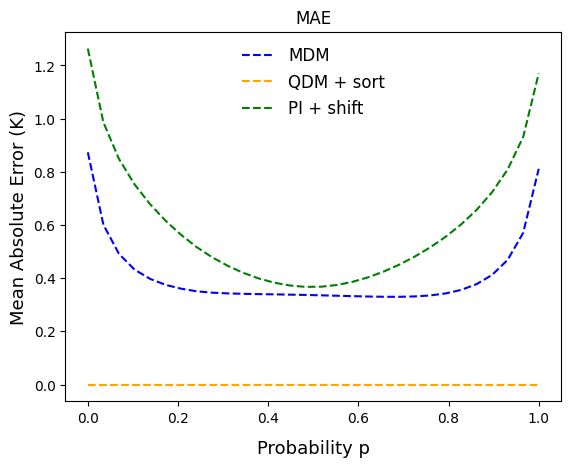

CPU times: user 151 ms, sys: 39.4 ms, total: 191 ms
Wall time: 624 ms


In [43]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,mdm_mae.sel(model_id=model_ids[-2],obs_id=obs_ids[-1]),'--',label='MDM',color = 'blue')
plt.plot(quants30,sqdm_mae.sel(model_id=model_ids[-2],obs_id=obs_ids[-1]),'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,shift_mae.sel(model_id=model_ids[-2],obs_id=obs_ids[-1]),'--',label='PI + shift', color = 'green')
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('MAE')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,2.0)
plt.show()

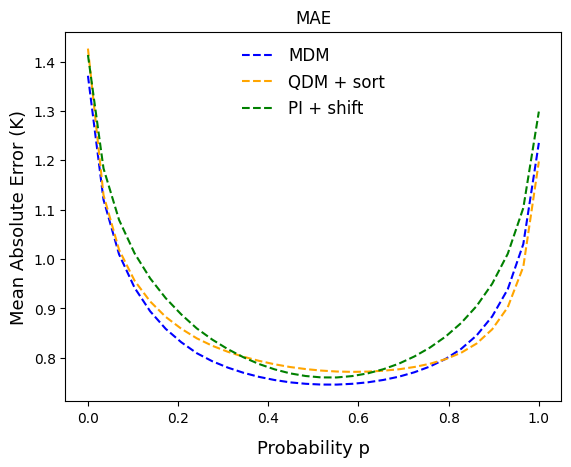

CPU times: user 123 ms, sys: 19.9 ms, total: 142 ms
Wall time: 148 ms


In [44]:
%%time
plt.plot(quants30,mdm_mae.sel(model_id=model_ids[-1],obs_id=obs_ids[-1]),'--',label='MDM',color = 'blue')
plt.plot(quants30,sqdm_mae.sel(model_id=model_ids[-1],obs_id=obs_ids[-1]),'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,shift_mae.sel(model_id=model_ids[-1],obs_id=obs_ids[-1]),'--',label='PI + shift', color = 'green')
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('MAE')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,2.0)
plt.show()

In [45]:
# mdm_mae.sel(model_id=model_ids[-2],obs_id=obs_ids[-1]).plot()
# plt.ylabel('Mean Absolute Error (K)')
# plt.xlabel('Percentiles')
# plt.title('MDM:' + var_name)

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [46]:
%%time
mdm_mae_flattened   = mdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
sqdm_mae_flattened  = sqdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
shift_mae_flattened = shift_mae.stack(pairs=('obs_id','model_id'),create_index=False)
mdm_mae_flattened

CPU times: user 2.07 ms, sys: 758 μs, total: 2.83 ms
Wall time: 5.8 ms


<xarray.DataArray 'tmax' (quantile: 30, pairs: 100)> Size: 24kB
dask.array<reshape, shape=(30, 100), dtype=float64, chunksize=(30, 100), chunktype=numpy.ndarray>
Coordinates:
    model_id  (pairs) <U12 5kB 'r18i1301p1f2' 'r3i1041p1f1' ... 'r10i1181p1f1'
    obs_id    (pairs) <U12 5kB 'r3i1231p1f1' 'r3i1231p1f1' ... 'r9i1171p1f2'
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
Dimensions without coordinates: pairs

In [47]:
average_mdm_mae   = mdm_mae_flattened.mean('pairs')
average_sqdm_mae  = sqdm_mae_flattened.mean('pairs')
average_shift_mae = shift_mae_flattened.mean('pairs')

In [48]:
%%time
average_mdm_mae.to_dataset().to_zarr(folder_path + 'mdm_mae_avg100pairs.zarr',mode='w')
average_sqdm_mae.to_dataset().to_zarr(folder_path + 'sqdm_mae_avg100pairs.zarr',mode='w')
average_shift_mae.to_dataset().to_zarr(folder_path + 'shift_mae_avg100pairs.zarr',mode='w')

CPU times: user 9.97 ms, sys: 17.8 ms, total: 27.7 ms
Wall time: 70 ms


In [49]:
%%time
average_mdm_mae_ds   = xr.open_zarr(folder_path + 'mdm_mae_avg100pairs.zarr')
average_sqdm_mae_ds  = xr.open_zarr(folder_path + 'sqdm_mae_avg100pairs.zarr')
average_shift_mae_ds = xr.open_zarr(folder_path + 'shift_mae_avg100pairs.zarr')
##
average_mdm_mae    = average_mdm_mae_ds[var_name]
average_sqdm_mae   = average_sqdm_mae_ds[var_name]
average_shift_mae  = average_shift_mae_ds[var_name]

CPU times: user 6.35 ms, sys: 0 ns, total: 6.35 ms
Wall time: 6.67 ms


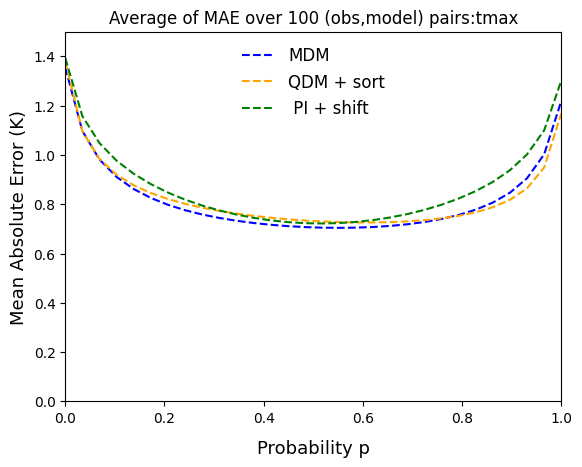

CPU times: user 116 ms, sys: 22.5 ms, total: 139 ms
Wall time: 163 ms


In [50]:
%%time
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'red')
plt.plot(quants30,average_shift_mae, '--',label =' PI + shift', color ='green')
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 100 (obs,model) pairs:'+ var_name)
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.5)
plt.show()

In [51]:
cluster.close()

### CMIP6 curves

In [52]:
# cmip6_average_mdm_mae  = xr.open_zarr(cvals + 'cmip6_mdm_mae_avg289pairs.zarr').tmax
# cmip6_average_sqdm_mae = xr.open_zarr(cvals + 'cmip6_sqdm_mae_avg289pairs.zarr').tmax

In [53]:
# %%time
# quants30        = np.linspace(0,1.0,30)
# plt.plot(quants30,cmip6_average_mdm_mae,'--',label='MDM',color = 'blue')
# plt.plot(quants30,cmip6_average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
# plt.legend(loc='upper center',prop={'size':12},frameon=False)
# #
# plt.title('Average of MAE over 306 (obs,model) pairs: CMIP6')
# plt.ylabel('Mean Absolute Error (K)',fontsize=13)
# plt.xlabel('Probability p',fontsize=13,labelpad=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,2.0)
# plt.show()

## Errors for CESM2 model

In [54]:
# %%time
# qgmc_gmaepath     = cvals+'qgmc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qgmsc_gmaepath    = cvals+'qgmsc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qgmc_gmae     = xr.open_zarr(qgmc_gmaepath).Error
# qgmsc_gmae    = xr.open_zarr(qgmsc_gmaepath).Error

In [55]:
# plt.plot(quants,qgmsc_gmae,label=r'$L_2(Q_i^m)-Q_f^m$',color='blue')
# plt.axhline(y = 0,linestyle = '--',label = 'QDM + sort', color = 'r') 
# plt.legend(loc='upper center',prop={'size':12},frameon=False)
# plt.title('')
# plt.ylabel('Mean Absolute Error (K)',fontsize=13)
# plt.xlabel('Probability p',fontsize=13,labelpad=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,2.0)
# plt.show()